In [27]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import resample


In [28]:
# load file
mat_data = scipy.io.loadmat('raw_emg.mat')
mat_data.keys()

dict_keys(['data', 'datastart', 'dataend', 'titles', 'rangemin', 'rangemax', 'unittext', 'unittextmap', 'blocktimes', 'tickrate', 'samplerate', 'firstsampleoffset', 'comtext', 'com'])

In [29]:
emg_data = mat_data['data']
# Start and end indices of data segments
data_start = mat_data['datastart']
data_end = mat_data['dataend']
titles = mat_data['titles']
comments = mat_data['comtext']
sampling_rate = mat_data['samplerate']
info = {
    "EMG Data Shape": emg_data.shape,
    "Data Start Indices": data_start,
    "Data End Indices": data_end,
    "Titles": titles,
    "Comments": comments,
    "Sampling Rate": sampling_rate
}
info

{'EMG Data Shape': (1, 1308032),
 'Data Start Indices': array([[1.000000e+00, 5.240100e+04, 2.448290e+05, 3.897370e+05,
         1.014765e+06],
        [1.310100e+04, 1.005080e+05, 2.810560e+05, 5.459940e+05,
         1.088082e+06],
        [2.620100e+04, 1.486150e+05, 3.172830e+05, 7.022510e+05,
         1.161399e+06],
        [3.930100e+04, 1.967220e+05, 3.535100e+05, 8.585080e+05,
         1.234716e+06]]),
 'Data End Indices': array([[  13100.,  100507.,  281055.,  545993., 1088081.],
        [  26200.,  148614.,  317282.,  702250., 1161398.],
        [  39300.,  196721.,  353509.,  858507., 1234715.],
        [  52400.,  244828.,  389736., 1014764., 1308032.]]),
 'Titles': array(['RMS Biceps ', 'RMS Triceps', 'Biceps     ', 'Triceps    '],
       dtype='<U11'),
 'Comments': array([], dtype='<U1'),
 'Sampling Rate': array([[200., 200., 200., 200., 200.],
        [200., 200., 200., 200., 200.],
        [200., 200., 200., 200., 200.],
        [200., 200., 200., 200., 200.]])}

In [30]:
# low-pass Butterworth filter (1 Hz cutoff)
def butter_lowpass_filter(data,cutoff=1,fs=200,order=1):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b,a = signal.butter(order,normal_cutoff,btype='low',analog=False)
    return signal.filtfilt(b,a,data)

In [31]:
# notch filter to remove powerline noise (50Hz)
def notch_filter(data, freq=50, fs=200, harmonics=3):
    for i in range(1, harmonics + 1):
        f0 = i * freq  # Harmonic frequency
        Q = 30  # Quality factor
        w0 = f0 / fs  # Normalize by sampling frequency
        if w0 > 0 and w0 < 1:  # Ensure w0 is within valid range
            b, a = signal.iirnotch(w0, Q)
            data = signal.filtfilt(b, a, data)
    return data

In [32]:
def plot_spectrum(data,fs,title):
    freqs,psd = signal.welch(data,fs,nperseg=1024)
    plt.figure(figsize=(10,5))
    plt.semilogy(freqs,psd)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.grid()
    plt.show()

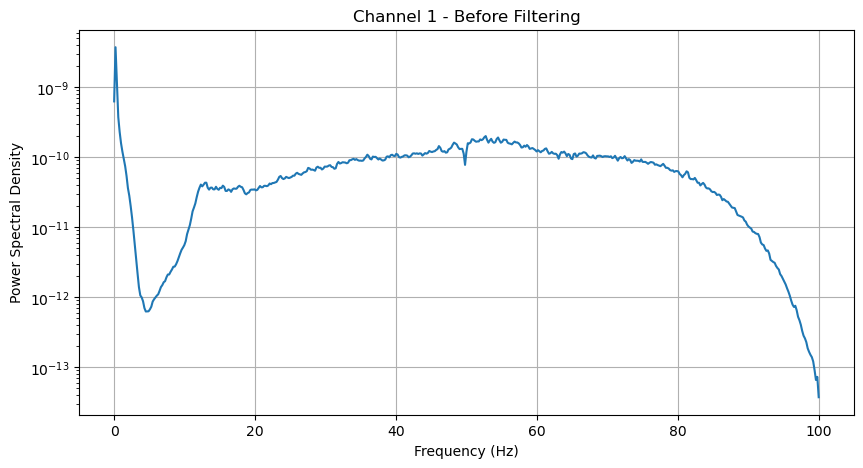

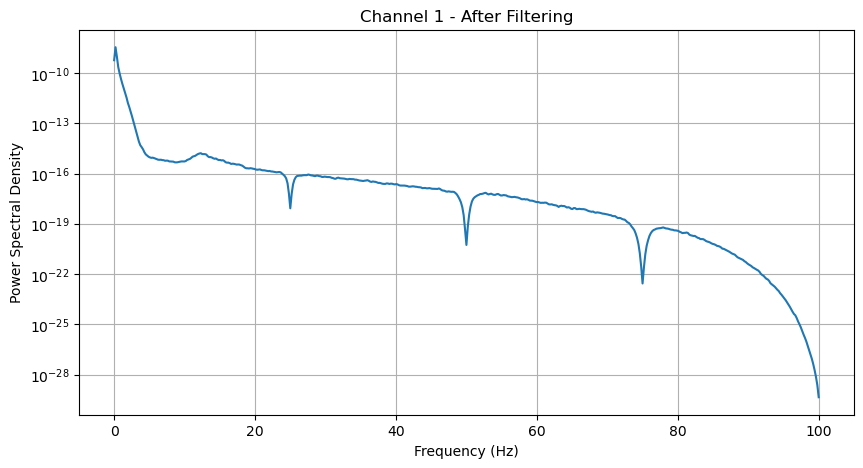

In [33]:
emg_channels = emg_data 
# filtering each channel
filtered_emg = []
for i in range(emg_channels.shape[0]):  # loop for channela
    raw_signal = emg_channels[i,:]    
    plot_spectrum(raw_signal,sampling_rate[0,0],f'Channel {i+1} - Before Filtering')
    # low-pass Butterworth filter
    lowpass_signal = butter_lowpass_filter(raw_signal,cutoff=1,fs=sampling_rate[0,0])
    # notch filter
    filtered_signal = notch_filter(lowpass_signal,freq=50,fs=sampling_rate[0,0])
    # Store filtered signal
    filtered_emg.append(filtered_signal)
    plot_spectrum(filtered_signal,sampling_rate[0,0],f'Channel {i+1} - After Filtering')
filtered_emg = np.array(filtered_emg)


In [34]:
def normalize_data(train_data,test_data,method='minmax'):
    if method == 'minmax':
        scaler = MinMaxScaler()  # Normalize between 0 and 1
    elif method == 'zscore':
        scaler = StandardScaler()  # Normalize to zero mean and unit variance
    train_normalized = scaler.fit_transform(train_data)
    test_normalized = scaler.transform(test_data)
    return train_normalized,test_normalized

In [35]:
# reshaping
emg_data_split = np.transpose(filtered_emg)  
train_data,test_data = train_test_split(emg_data_split,test_size=0.2,random_state=42)
# normalization method
method = 'zscore'  # or 'minmax'
train_normalized,test_normalized = normalize_data(train_data,test_data,method)
print(f"Train Data (first 5 Samples,{method} Normalized):\n",train_normalized[:5])
print(f"Test Data (first 5 Samples,{method} Normalized):\n",test_normalized[:5])

Train Data (first 5 Samples,zscore Normalized):
 [[-0.55836717]
 [-0.56700244]
 [-0.61679647]
 [-0.57285677]
 [-0.61899032]]
Test Data (first 5 Samples,zscore Normalized):
 [[-0.17965693]
 [ 1.86057104]
 [-0.28969752]
 [-0.57490534]
 [-0.56376006]]


The normalization method used in your output is **Z-Score Normalization**.

### **What is Z-Score Normalization?**
Z-Score Normalization, also known as **standardization**, transforms the data such that:
- The **mean** of the data becomes **0**.
- The **standard deviation** becomes **1**.

For a data point \( x \), the formula for Z-Score normalization is:
\[
x' = \frac{x - \mu}{\sigma}
\]
Where:
- \( x \): Original data point.
- \( \mu \): Mean of the data (calculated from the training set).
- \( \sigma \): Standard deviation of the data (calculated from the training set).

### **How it works:**
1. **Training Data**:
   - Compute the mean (\( \mu \)) and standard deviation (\( \sigma \)) of the training data.
   - Transform all training data points using the formula \( x' \).
2. **Test Data**:
   - Apply the same mean (\( \mu \)) and standard deviation (\( \sigma \)) from the training set to transform the test data.

### **Why use Z-Score Normalization?**
- It is particularly useful when the data has different scales or units.
- Many machine learning algorithms (like SVM, KNN, or neural networks) work better when the data is centered and scaled.
- Ensures that features with larger ranges do not dominate the learning process.

### **Why not Min-Max Normalization?**
- **Min-Max Normalization** scales the data to a specific range (e.g., [0, 1]).
- However, Min-Max can be sensitive to outliers because extreme values in the data directly affect the range.

### **When is Z-Score Better?**
Z-Score is preferred:
- When data contains outliers.
- When the goal is to compare values relative to the dataset distribution (centered around the mean).

In your case:
- The **Z-Score Normalization** ensures that the EMG signals are scaled consistently without being skewed by extreme values.

Let me know if you'd like further clarifications or want to proceed with the next steps!

In [36]:
# windowing parameters
sampling_rate = 200  # Hz
window_duration = 0.2  # seconds
overlap_duration = 0.19  # seconds
samples_per_window = int(window_duration * sampling_rate)  # 200 ms window -> 40 samples
overlap_samples = int(overlap_duration * sampling_rate)  # 190 ms overlap -> 38 samples
step_size = samples_per_window - overlap_samples  # 40 - 38 = 2 samples

# segmenting signal into overlapping windows
def segment_signal(data,samples_per_window,step_size):
    windows = []
    for start in range(0,len(data) - samples_per_window + 1,step_size):
        window = data[start : start + samples_per_window]
        windows.append(window)
    return np.array(windows)

# apply segmentation
segmented_data = []
for channel in filtered_emg:
    windows = segment_signal(channel,samples_per_window,step_size)
    segmented_data.append(windows)
segmented_data = np.array(segmented_data)  # shape: [Channels,Windows,Samples]
print(f"Segmented Data Shape: {segmented_data.shape}")

Segmented Data Shape: (1, 653997, 40)


Calculate the number of samples per window:


Samples per window=Window duration (in seconds)×Sampling rate
For a window of 200 ms and a sampling rate of 200 Hz:

Samples per window=0.2×200=40
Calculate the step size (non-overlapping portion of the window):


Step size=Window size−Overlap size
With an overlap of 190 ms (190 ms = 0.19 × 200 Hz = 38 samples):


Step size=40−38=2
Create sliding windows:

Use a sliding window function to extract windows of 40 samples, moving by 2 samples each step.

The segmentation has been successfully completed. Here's what the output means:

- **Channels**: 1 (the EMG data is from a single channel in this case).
- **Windows**: 653,997 (total number of overlapping windows created).
- **Samples per Window**: 40 (each window corresponds to 200 ms of data).

This result confirms that the signal has been divided into 200 ms windows with a 190 ms overlap (10 ms step size).


In [37]:
def extract_features(window):
    features = {
        "MAV": np.mean(np.abs(window)),
        "STD": np.std(window),
        "VAR": np.var(window),
        "WL": np.sum(np.abs(np.diff(window))),
        "ZC": np.sum(np.diff(np.sign(window)) != 0),
        "RMS": np.sqrt(np.mean(window ** 2)),
        "SSC": np.sum(np.diff(np.sign(np.diff(window))) != 0),
    }
    return features

# Extract features for each window
feature_list = []
for channel_idx,channel_windows in enumerate(segmented_data):
    for window_idx,window in enumerate(channel_windows):
        features = extract_features(window)
        features["Channel"] = channel_idx  # channel information
        features["Window"] = window_idx  # window index
        feature_list.append(features)

features_df = pd.DataFrame(feature_list)
features_df.to_csv("features_with_labels.csv",index=False)
print(features_df.head())


        MAV           STD           VAR            WL  ZC       RMS  SSC  \
0  0.000013  9.324244e-08  8.694152e-15  3.181447e-07   0  0.000013    0   
1  0.000012  9.929018e-08  9.858541e-15  3.387502e-07   0  0.000012    0   
2  0.000012  1.057151e-07  1.117568e-14  3.606131e-07   0  0.000012    0   
3  0.000012  1.125378e-07  1.266476e-14  3.836450e-07   0  0.000012    0   
4  0.000012  1.197686e-07  1.434453e-14  4.079166e-07   0  0.000012    0   

   Channel  Window  
0        0       0  
1        0       1  
2        0       2  
3        0       3  
4        0       4  


MAV: Mean Absolute Value of the signal in each window. 


STD: Standard Deviation, representing signal variability.


VAR: Variance, the squared variability of the signal.


WL: Waveform Length, an indicator of signal complexity.


ZC: Zero Crossing, representing the number of times the signal crosses the zero line.


RMS: Root Mean Square, measuring signal power.


SSC: Slope Sign Change, indicating the number of changes in the signal's slope.


Channel: The EMG channel index (e.g., 0 for the first channel).


Window: The window index within the signal.


In [38]:
actions = ['rest','grip','rest','up','rest','down','rest','right','rest','left','rest','rotate','rest']
repetitions = 25
total_windows = len(features_df)
# windows per action dynamically
windows_per_action = total_windows // (len(actions) * repetitions)
# labels based on the exact number of windows per action
labels = []
for _ in range(repetitions):
    for action in actions:
        labels.extend([action] * windows_per_action)

remaining_windows = total_windows - len(labels)
if remaining_windows > 0:
    labels.extend([actions[-1]] * remaining_windows)
# Ensure the labels match the number of rows in features_df
features_df['Label'] = labels[:total_windows]


Label Distribution:
 Label
rest      352197
grip       50300
up         50300
down       50300
right      50300
left       50300
rotate     50300
Name: count, dtype: int64


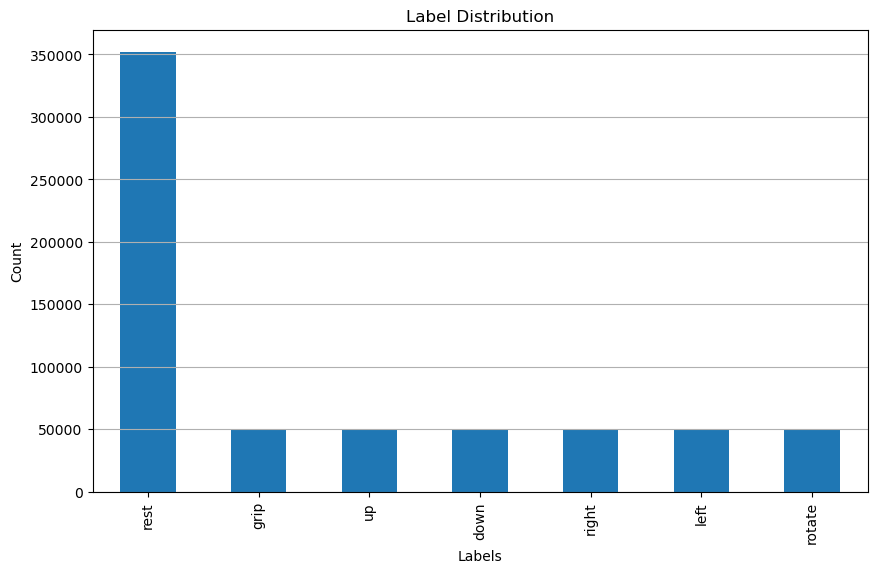

In [39]:
label_counts = features_df['Label'].value_counts()
print("\nLabel Distribution:\n",label_counts)
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


In [40]:
# evaluate model performance
def evaluate_model(y_true,y_pred,model_name):
    print(f"\nResults for {model_name}:")
    print("Confusion Matrix:")
    # Confusion Matrix
    cm = confusion_matrix(y_true,y_pred,labels=y.unique())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=y.unique(),yticklabels=y.unique())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_true,y_pred))
    # accuracy
    accuracy = accuracy_score(y_true,y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    return accuracy



Results for Random Forest:
Confusion Matrix:


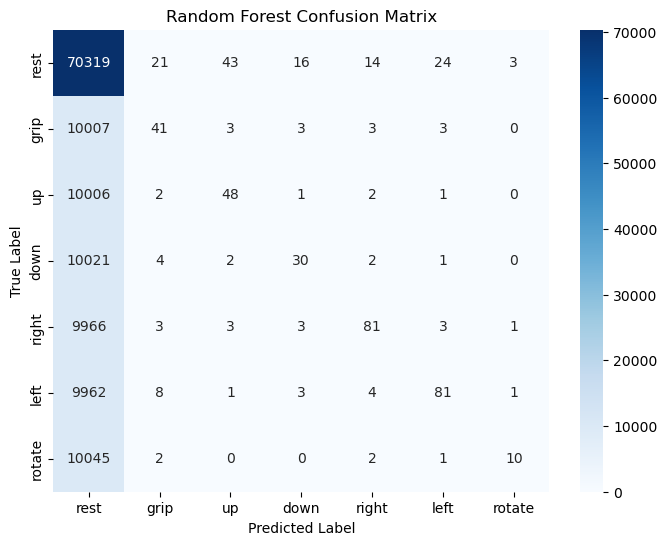


Classification Report:
              precision    recall  f1-score   support

        down       0.54      0.00      0.01     10060
        grip       0.51      0.00      0.01     10060
        left       0.71      0.01      0.02     10060
        rest       0.54      1.00      0.70     70440
       right       0.75      0.01      0.02     10060
      rotate       0.67      0.00      0.00     10060
          up       0.48      0.00      0.01     10060

    accuracy                           0.54    130800
   macro avg       0.60      0.15      0.11    130800
weighted avg       0.57      0.54      0.38    130800

Accuracy: 0.54
Random Forest Accuracy: 0.54


In [41]:
# features (X) ,labels (y)
X = features_df.drop(columns=['Channel','Window','Label'])  
y = features_df['Label'] 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)  # Random Forest with 100 trees
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = evaluate_model(y_test,y_pred_rf,"Random Forest")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")



Results for KNN:
Confusion Matrix:


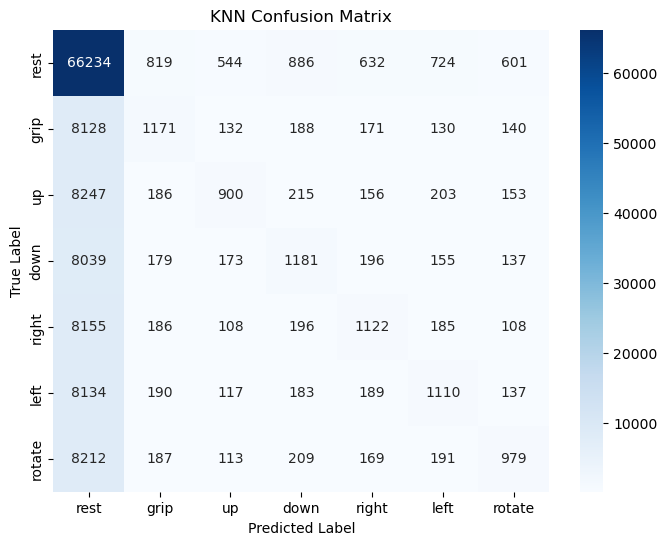


Classification Report:
              precision    recall  f1-score   support

        down       0.39      0.12      0.18     10060
        grip       0.40      0.12      0.18     10060
        left       0.41      0.11      0.17     10060
        rest       0.58      0.94      0.71     70440
       right       0.43      0.11      0.18     10060
      rotate       0.43      0.10      0.16     10060
          up       0.43      0.09      0.15     10060

    accuracy                           0.56    130800
   macro avg       0.44      0.23      0.25    130800
weighted avg       0.50      0.56      0.46    130800

Accuracy: 0.56

KNN Accuracy: 0.56


In [42]:
knn_model = KNeighborsClassifier(n_neighbors=20,n_jobs=-1)
knn_model.fit(X_train,y_train)
y_pred_svm = knn_model.predict(X_test)
knn_model = evaluate_model(y_test,y_pred_svm,"KNN")
print(f"\nKNN Accuracy: {knn_model:.2f}")

### **Challenges and Solutions for Improving Accuracy in This Experiment**
Dataset has **class imbalance** because **"rest"** label dominates dataset. Here are key challenges and solutions:

---

## **🔴 Challenge 1: Class Imbalance**
### **Problem:**
- **"rest"** class has **352,197 samples**, while other classes (e.g., "grip", "up", etc.) have only **50,300 samples**.
- **Machine learning models tend to predict majority class ("rest") more frequently, reducing accuracy for minority classes.**
- This can result in **high overall accuracy but poor per-class performance**.

### ✅ **Solution:**
1. **Downsample Majority Class ("rest")**:
   - Reduce "rest" samples to match other classes (~50,300 samples).
   - Keeps dataset balanced for better learning.


## **🔴 Challenge 2: Overlapping Features**
### **Problem:**
- Some movements (e.g., "grip" vs. "down") might have **similar EMG patterns**, causing misclassification.
- **Feature overlap** makes it hard for classifiers to distinguish between movements.

### ✅ **Solution:**
1. **Extract More Discriminative Features**:
   - Current features: **MAV, STD, RMS, ZC, WL, SSC**.
   - **Adding Frequency Domain Features** (Power Spectrum, Mean Frequency).

   ```

2. **Use Feature Selection (PCA or Mutual Information)**:
   - Selecting only **the most important features** to improve classification.
   ```python

---

## **🔴 Challenge 3: Choosing Right Model**
### **Problem:**
- Some models may **overfit** (Random Forest), while others **struggle with non-linearity** (LDA).
- SVM works well but is **computationally expensive** for large datasets.

### ✅ **Solution:**
1. Try Deep Learning (if dataset is large enough)
  
   ```
   ✅ Why? Deep learning can learn complex patterns better than traditional ML.

---

| Problem | Solution |
|---------|----------|
| **Class Imbalance** | Downsample "rest", use `class_weight='balanced'` |
| **Feature Overlap** | Adding **frequency domain features**, use PCA |
| **Slow Models** | Use **XGBoost** instead of SVM |
| **Limited Feature Set** | Extract **Power Spectrum, Spectral Entropy** |
| **Deep Learning Option** | Use **Neural Networks (if dataset is large enough)** |

---


In [ ]:
# Separate majority and minority classes
rest_df = features_df[features_df['Label'] == 'rest']
other_df = features_df[features_df['Label'] != 'rest']
# downsample "rest" class
rest_downsampled = resample(rest_df,replace=False,n_samples=50300,random_state=42)
# Combine downsampled "rest" with other classes
balanced_df = pd.concat([rest_downsampled,other_df])
print("Balanced Dataset:\n",balanced_df['Label'].value_counts())

Balanced Dataset:
 Label
rest      50300
grip      50300
up        50300
down      50300
right     50300
left      50300
rotate    50300
Name: count, dtype: int64



Results for Random Forest:
Confusion Matrix:


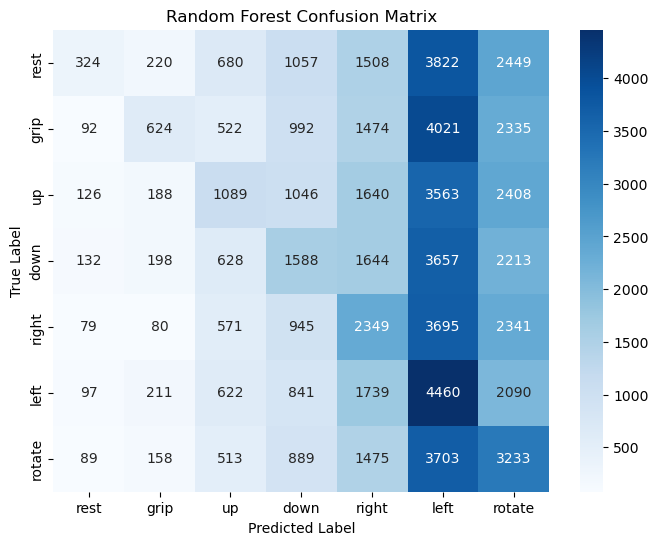


Classification Report:
              precision    recall  f1-score   support

        down       0.22      0.16      0.18     10060
        grip       0.37      0.06      0.11     10060
        left       0.17      0.44      0.24     10060
        rest       0.35      0.03      0.06     10060
       right       0.20      0.23      0.21     10060
      rotate       0.19      0.32      0.24     10060
          up       0.24      0.11      0.15     10060

    accuracy                           0.19     70420
   macro avg       0.25      0.19      0.17     70420
weighted avg       0.25      0.19      0.17     70420

Accuracy: 0.19
Random Forest Accuracy: 0.19


In [44]:
X = balanced_df.drop(columns=['Channel','Window','Label'])  
y = balanced_df['Label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = evaluate_model(y_test,y_pred_rf,"Random Forest")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")



Results for KNN:
Confusion Matrix:


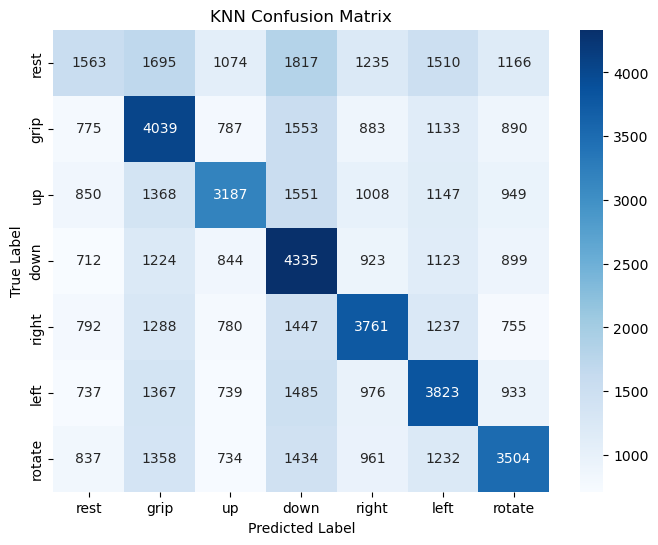


Classification Report:
              precision    recall  f1-score   support

        down       0.32      0.43      0.37     10060
        grip       0.33      0.40      0.36     10060
        left       0.34      0.38      0.36     10060
        rest       0.25      0.16      0.19     10060
       right       0.39      0.37      0.38     10060
      rotate       0.39      0.35      0.37     10060
          up       0.39      0.32      0.35     10060

    accuracy                           0.34     70420
   macro avg       0.34      0.34      0.34     70420
weighted avg       0.34      0.34      0.34     70420

Accuracy: 0.34

KNN Accuracy: 0.34


In [45]:
knn_model = KNeighborsClassifier(n_neighbors=10,n_jobs=-1)
knn_model.fit(X_train,y_train)
y_pred_svm = knn_model.predict(X_test)
knn_model = evaluate_model(y_test,y_pred_svm,"KNN")
print(f"\nKNN Accuracy: {knn_model:.2f}")